In [5]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [6]:
# version
print("Tensorflow version", tf.__version__)

Tensorflow version 2.12.0


In [7]:
# explore data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
display(train.head())
display(test.head())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


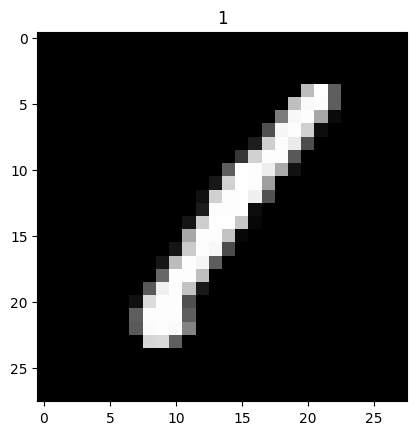

In [8]:
sample = train.iloc[0, 1:].to_numpy()
label = train.iloc[0, 0]
sample = sample.reshape(28, 28)
plt.title(label)
plt.imshow(sample, cmap="gray")

Minimum pixel value:  0
Maximum pixel value:  255


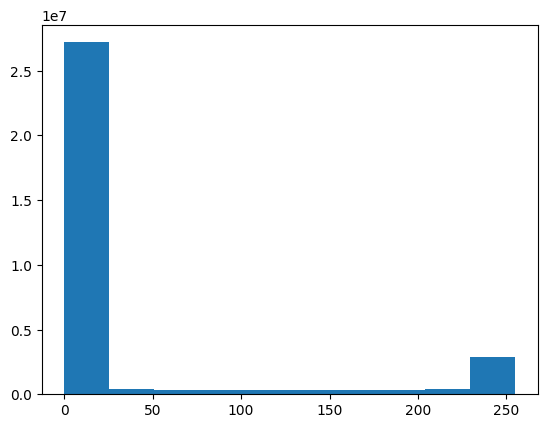

In [9]:
def display_distribution(data: np.array) -> None:    
    plt.hist(data)
    print("Minimum pixel value: ", np.min(data))
    print("Maximum pixel value: ", np.max(data))
    plt.show()


display_distribution(train.iloc[:, 1:].to_numpy().reshape(-1))

Minimum pixel value:  0
Maximum pixel value:  255


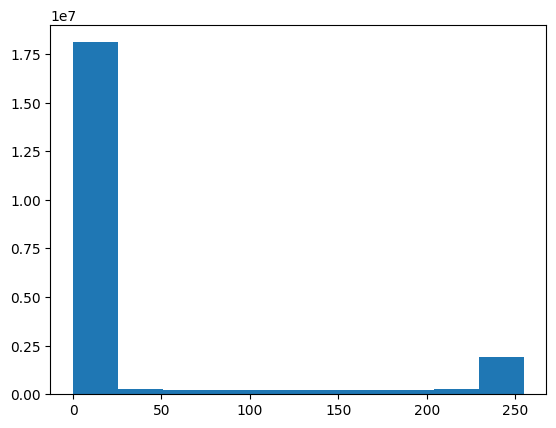

In [10]:
display_distribution(test.iloc[:, 1:].to_numpy().reshape(-1))

training and testing data has similar distribution with value ranges from 0 to 255

In [39]:
# prepare data
# shuffle train data
train = train.sample (frac=1, random_state=42).reset_index(drop=True)

# split data between training and validation
train_size, val_size = int(0.8*len(train)), int(0.2*len(train))
train, val = train.iloc[:train_size, :], train.iloc[train_size:, :]


def np_to_dataset(
        images: np.array, 
        labels: np.array
    ) -> tf.data.Dataset:
    """Function used to convert numpy to tf.data.Dataset"""
    return tf.data.Dataset.from_tensor_slices((images, labels))

# 
train_dataset = np_to_dataset(train.iloc[:, 1:].to_numpy(), train.iloc[:, 0].to_numpy())
val_dataset = np_to_dataset(val.iloc[:, 1:].to_numpy(), val.iloc[:, 0].to_numpy())
test_dataset = np_to_dataset(test.to_numpy(), test.to_numpy())

In [40]:
# data preprocessing using tf.data api
def normalize(image, label) -> tuple:
    """Normalize image"""
    image = image/255
    return tf.cast(image, tf.dtypes.float32), tf.cast(label, tf.dtypes.uint8)

def preprocess(data: tf.data.Dataset) -> tf.data.Dataset:
    # normalize image by dividing it by 255
    data = data.map(lambda image, label: normalize(image, label), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return data

train_dataset = preprocess(train_dataset)
val_dataset = preprocess(val_dataset)
test_dataset = preprocess(test_dataset)

# Multilayer Perceptrion

In [10]:
# create neural network
def mlp_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(784,)),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ],
    name="multilayer_perceptron"
    )
    return model

model_original = mlp_model()
model = tf.keras.models.clone_model(model_original)
model.summary()

Model: "multilayer_perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [11]:
OPTIMIZER_NAME = "rmsprop"
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 10

In [12]:

# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# callbacks for finding the best model
date = datetime.datetime.now().strftime("%Y%m%d")
epochs=20

model_path = "models/mlp/opt_%s_lr_%s_batch_%s_epochs_%s_date_%s" \
          %(OPTIMIZER_NAME, LEARNING_RATE, BATCH_SIZE, EPOCHS, date)

log_dir = "logs/mlp/opt_%s_lr_%s_batch_%s_epochs_%s_date_%s" \
          %(OPTIMIZER_NAME, LEARNING_RATE, BATCH_SIZE, EPOCHS, date)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2),
    tf.keras.callbacks.ModelCheckpoint(
        filepath = model_path, 
        monitor = 'val_accuracy', 
        save_best_only = True,
        mode = 'max', 
        verbose = 2,
    ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
]

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# train
model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[callbacks]
)




Epoch 1/10
523/525 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.9110
Epoch 1: val_accuracy improved from -inf to 0.94833, saving model to models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


525/525 [==============================] - 4s 6ms/step - loss: 0.3017 - accuracy: 0.9112 - val_loss: 0.1714 - val_accuracy: 0.9483
Epoch 2/10
520/525 [============================>.] - ETA: 0s - loss: 0.1179 - accuracy: 0.9648
Epoch 2: val_accuracy improved from 0.94833 to 0.96036, saving model to models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


525/525 [==============================] - 3s 5ms/step - loss: 0.1174 - accuracy: 0.9649 - val_loss: 0.1293 - val_accuracy: 0.9604
Epoch 3/10
520/525 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9779
Epoch 3: val_accuracy improved from 0.96036 to 0.96726, saving model to models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


525/525 [==============================] - 3s 5ms/step - loss: 0.0729 - accuracy: 0.9780 - val_loss: 0.1102 - val_accuracy: 0.9673
Epoch 4/10
515/525 [============================>.] - ETA: 0s - loss: 0.0474 - accuracy: 0.9858
Epoch 4: val_accuracy improved from 0.96726 to 0.96869, saving model to models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


525/525 [==============================] - 3s 6ms/step - loss: 0.0474 - accuracy: 0.9858 - val_loss: 0.1058 - val_accuracy: 0.9687
Epoch 5/10
511/525 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9904
Epoch 5: val_accuracy did not improve from 0.96869
525/525 [==============================] - 2s 4ms/step - loss: 0.0329 - accuracy: 0.9904 - val_loss: 0.1213 - val_accuracy: 0.9673
Epoch 6/10
520/525 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9924
Epoch 6: val_accuracy improved from 0.96869 to 0.97107, saving model to models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


525/525 [==============================] - 3s 5ms/step - loss: 0.0258 - accuracy: 0.9924 - val_loss: 0.1156 - val_accuracy: 0.9711
Epoch 7/10
517/525 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9933
Epoch 7: val_accuracy did not improve from 0.97107
525/525 [==============================] - 2s 4ms/step - loss: 0.0220 - accuracy: 0.9933 - val_loss: 0.1243 - val_accuracy: 0.9682
Epoch 8/10
519/525 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9934
Epoch 8: val_accuracy improved from 0.97107 to 0.97393, saving model to models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


INFO:tensorflow:Assets written to: models/mlp\opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702\assets


525/525 [==============================] - 3s 6ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.1215 - val_accuracy: 0.9739
Epoch 9/10
515/525 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9933
Epoch 9: val_accuracy did not improve from 0.97393
525/525 [==============================] - 2s 5ms/step - loss: 0.0202 - accuracy: 0.9933 - val_loss: 0.1245 - val_accuracy: 0.9730
Epoch 9: early stopping


In [41]:
best_model = tf.keras.models.load_model("models/mlp/opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702/")
test_dataset = test_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
results = best_model.predict(test_dataset)

219/219 [==============================] - 1s 2ms/step


In [45]:
results = np.argmax(results, axis=1)
submission = pd.DataFrame({
    'ImageId': np.arange(len(results)),
    'Label': results 
})
submission.to_csv("submissions/20230207_mlp_opt_rmsprop_lr_0.001_batch_64_epochs_10_date_20230702.csv", index=False)

# Convolutional Neural Network